[*********************100%***********************]  1 of 1 completed


🔮 XGBoost RMSE: 104.66
📏 XGBoost MAE: 97.86
📉 XGBoost MAPE: 1.63%
📈 XGBoost Directional Accuracy: 13.79%
📊 XGBoost R2 Score: -1.2038
🔗 Pearson Correlation: 0.5921


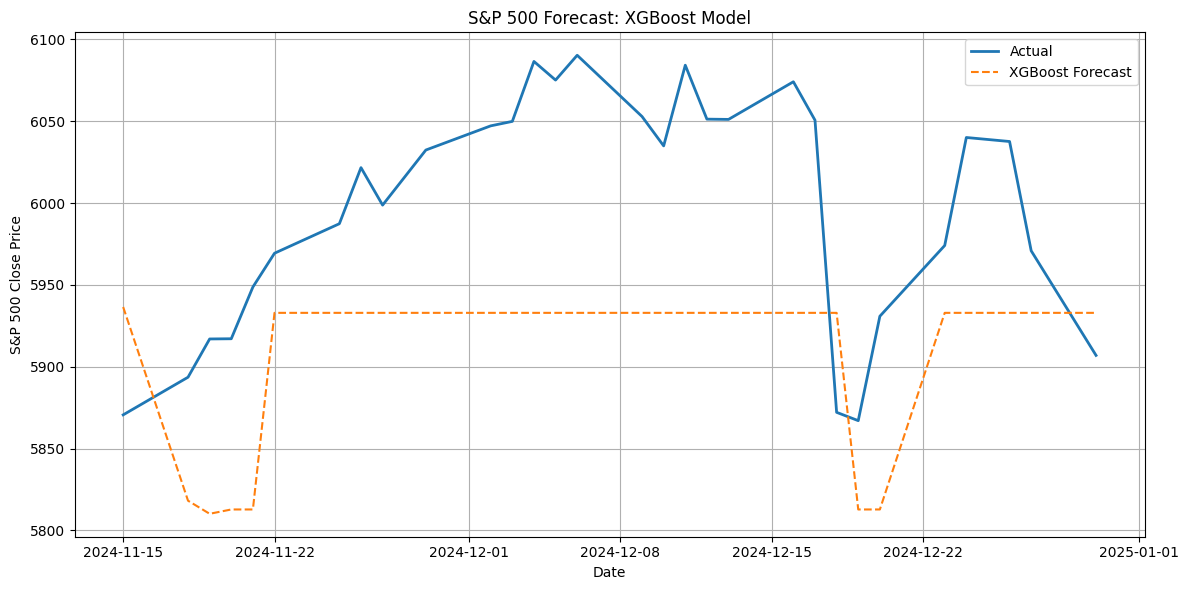

In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from scipy.stats import pearsonr

# Step 1: Download the data
sp500 = yf.download('^GSPC', start='2020-01-01', end='2024-12-31')

# Use only 'Close' price and drop NaNs
data = sp500[['Close']].dropna()

# Step 2: Train-test split (last 30 days test)
train_data = data[:-30]
test_data = data[-30:]

# Step 3: Scale data to [0,1] range (optional for tree-based models but keep for consistency)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train_data)
scaled_test = scaler.transform(test_data)

# Step 4: Prepare sequences for XGBoost (flatten sequences as feature vectors)
def create_sequences_flat(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length].flatten())  # flatten sequence window
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X_train, y_train = create_sequences_flat(scaled_train, seq_length)

# For test, use last part of full data
full_data = np.concatenate((scaled_train, scaled_test), axis=0)
X_test, y_test = create_sequences_flat(full_data[-(30+seq_length):], seq_length)

# Step 5: Initialize and train XGBoost regressor
xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    objective='reg:squarederror',
    random_state=42
)

xgb_model.fit(X_train, y_train.ravel())

# Step 6: Predict on test set
y_pred_scaled = xgb_model.predict(X_test).reshape(-1, 1)

# Inverse scale predictions and true values
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# Step 7: Calculate metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)
pearson_corr, _ = pearsonr(y_true.flatten(), y_pred.flatten())
# Directional accuracy
actual_diff = y_true[1:] - y_true[:-1]
pred_diff = y_pred[1:] - y_pred[:-1]
directional_accuracy = np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

print(f"🔮 XGBoost RMSE: {rmse:.2f}")
print(f"📏 XGBoost MAE: {mae:.2f}")
print(f"📉 XGBoost MAPE: {mape:.2f}%")
print(f"📈 XGBoost Directional Accuracy: {directional_accuracy:.2f}%")
print(f"📊 XGBoost R2 Score: {r2:.4f}")
print(f"🔗 Pearson Correlation: {pearson_corr:.4f}")
# Step 8: Plot actual vs predicted for test set
dates_test = data.index[-30:]

plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_true.flatten(), label='Actual', linewidth=2)
plt.plot(dates_test, y_pred.flatten(), label='XGBoost Forecast', linestyle='--')
plt.title('S&P 500 Forecast: XGBoost Model')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
!pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 1.3/150.0 MB 4.5 MB/s eta 0:00:34
    --------------------------------------- 3.7/150.0 MB 7.3 MB/s eta 0:00:21
   - -------------------------------------- 5.5/150.0 MB 7.8 MB/s eta 0:00:19
   - -------------------------------------- 7.3/150.0 MB 8.1 MB/s eta 0:00:18
   -- ------------------------------------- 9.2/150.0 MB 8.3 MB/s eta 0:00:18
   -- ------------------------------------- 11.0/150.0 MB 8.4 MB/s eta 0:00:17
   --- ------------------------------------ 12.6/150.0 MB 8.2 MB/s eta 0:00:17
   --- ------------------------------------ 13.9/150.0 MB 8.1 MB/s eta 0:00:17
   ---- ----------------------------------- 15.5/150.0 MB 8.0 MB/s eta 0:00:17
   ---- ----------------------------------- 17.0/150.0 MB 7.9 MB/s eta 0:00:17
   ---- ----------------------------------- 18.6/150.0 MB 7.9 MB/s eta 0:


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
